In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [17]:
file_path = "/Users/pranaykumar/Documents/GitHub/prosperity-3/round3/data/prices_round_3_day_0.csv"
df = pd.read_csv(file_path, delimiter=';')
Strike10000 = df[df['product'] == "VOLCANIC_ROCK_VOUCHER_10000"]
rock = df[df['product'] == "VOLCANIC_ROCK"]

In [19]:
rock

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
13,0,0,VOLCANIC_ROCK,10502.0,205.0,NaN,NaN,NaN,NaN,10504,146,10505.0,59.0,NaN,NaN,10503.0,0.0
21,0,100,VOLCANIC_ROCK,10509.0,192.0,NaN,NaN,NaN,NaN,10511,122,10512.0,70.0,NaN,NaN,10510.0,0.0
31,0,200,VOLCANIC_ROCK,10512.0,167.0,NaN,NaN,NaN,NaN,10514,109,10515.0,58.0,NaN,NaN,10513.0,0.0
55,0,300,VOLCANIC_ROCK,10517.0,118.0,10516.0,68.0,NaN,NaN,10518,118,10519.0,68.0,NaN,NaN,10517.5,0.0
60,0,400,VOLCANIC_ROCK,10509.0,128.0,10508.0,73.0,NaN,NaN,10510,128,10511.0,73.0,NaN,NaN,10509.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139932,0,999500,VOLCANIC_ROCK,10514.0,126.0,10513.0,79.0,NaN,NaN,10515,126,10516.0,79.0,NaN,NaN,10514.5,0.0
139950,0,999600,VOLCANIC_ROCK,10511.0,163.0,NaN,NaN,NaN,NaN,10512,6,10513.0,111.0,10514.0,52.0,10511.5,0.0
139971,0,999700,VOLCANIC_ROCK,10513.0,111.0,10512.0,54.0,NaN,NaN,10514,111,10515.0,54.0,NaN,NaN,10513.5,0.0
139979,0,999800,VOLCANIC_ROCK,10514.0,117.0,10513.0,76.0,NaN,NaN,10515,117,10516.0,76.0,NaN,NaN,10514.5,0.0


In [20]:
Strike10000

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0
16,0,100,VOLCANIC_ROCK_VOUCHER_10000,515.0,13.0,NaN,NaN,NaN,NaN,516,13,NaN,NaN,NaN,NaN,515.5,0.0
39,0,200,VOLCANIC_ROCK_VOUCHER_10000,516.0,15.0,NaN,NaN,NaN,NaN,517,15,NaN,NaN,NaN,NaN,516.5,0.0
44,0,300,VOLCANIC_ROCK_VOUCHER_10000,521.0,13.0,NaN,NaN,NaN,NaN,522,13,NaN,NaN,NaN,NaN,521.5,0.0
62,0,400,VOLCANIC_ROCK_VOUCHER_10000,512.0,15.0,NaN,NaN,NaN,NaN,513,15,NaN,NaN,NaN,NaN,512.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139936,0,999500,VOLCANIC_ROCK_VOUCHER_10000,515.0,12.0,NaN,NaN,NaN,NaN,516,12,NaN,NaN,NaN,NaN,515.5,0.0
139954,0,999600,VOLCANIC_ROCK_VOUCHER_10000,514.0,13.0,NaN,NaN,NaN,NaN,515,13,NaN,NaN,NaN,NaN,514.5,0.0
139967,0,999700,VOLCANIC_ROCK_VOUCHER_10000,515.0,13.0,NaN,NaN,NaN,NaN,516,13,NaN,NaN,NaN,NaN,515.5,0.0
139975,0,999800,VOLCANIC_ROCK_VOUCHER_10000,516.0,19.0,NaN,NaN,NaN,NaN,517,19,NaN,NaN,NaN,NaN,516.5,0.0


In [ ]:
def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Implied vol using Brent's method
def implied_volatility_call(S, V_market, K, T, r):
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, r, sigma) - V_market, 1e-6, 5.0)
    except ValueError:
        return np.nan  # can't solve (e.g. market price too low/high)

# Merge the two dataframes on timestamp
merged = pd.merge(Strike10000[['timestamp', 'mid_price']], rock[['timestamp', 'mid_price']],
                  on='timestamp', suffixes=('_option', '_underlying'))

# Add Black-Scholes inputs
K = 10000
T = 5 / 365  # or use 5/252 for trading days
r = 0.05

# Compute implied volatility
merged['implied_vol'] = merged.apply(lambda row: 
    implied_volatility_call(row['mid_price_underlying'], row['mid_price_option'], K, T, r), axis=1)

# Check the result
merged[['timestamp', 'mid_price_underlying', 'mid_price_option', 'implied_vol']].head()

,timestamp,mid_price_underlying,mid_price_option,implied_vol
0,0,10503.0,505.5,NaN
1,100,10510.0,515.5,NaN
2,200,10513.0,516.5,NaN
3,300,10517.5,521.5,NaN
4,400,10509.5,512.5,NaN


In [22]:
def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_volatility_call(S, V_market, K, T, r):
    # Check arbitrage bounds
    intrinsic = max(S - K, 0)
    upper_bound = S
    if not (intrinsic <= V_market <= upper_bound):
        return np.nan
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, r, sigma) - V_market, 1e-6, 5.0)
    except ValueError:
        return np.nan

# Example inputs
K = 10000
T = 5 / 365  # days to maturity
r = 0.05

# Merge and compute mid prices
Strike10000['mid_price'] = (Strike10000['bid_price_1'] + Strike10000['ask_price_1']) / 2
rock['mid_price'] = (rock['bid_price_1'] + rock['ask_price_1']) / 2

# Merge dataframes on timestamp
merged = pd.merge(Strike10000[['timestamp', 'mid_price']], 
                  rock[['timestamp', 'mid_price']], 
                  on='timestamp', suffixes=('_option', '_underlying'))

# Compute implied vol
merged['implied_vol'] = merged.apply(lambda row: 
    implied_volatility_call(row['mid_price_underlying'], row['mid_price_option'], K, T, r), axis=1)

# Final output
print(merged[['timestamp', 'mid_price_underlying', 'mid_price_option', 'implied_vol']].head())

/var/folders/zz/mqrj5zdn3wxcyfk2rn4vkms00000gn/T/ipykernel_7328/2934537142.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Strike10000['mid_price'] = (Strike10000['bid_price_1'] + Strike10000['ask_price_1']) / 2
/var/folders/zz/mqrj5zdn3wxcyfk2rn4vkms00000gn/T/ipykernel_7328/2934537142.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rock['mid_price'] = (rock['bid_price_1'] + rock['ask_price_1']) / 2


   timestamp  mid_price_underlying  mid_price_option  implied_vol
0          0               10503.0             505.5          NaN
1        100               10510.0             515.5          NaN
2        200               10513.0             516.5          NaN
3        300               10517.5             521.5          NaN
4        400               10509.5             512.5          NaN


In [24]:
merged['implied_vol']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9995   NaN
9996   NaN
9997   NaN
9998   NaN
9999   NaN
Name: implied_vol, Length: 10000, dtype: float64

In [25]:
def debug_and_compute_iv(row):
    S = row['mid_price_underlying']
    V_market = row['mid_price_option']
    
    # Step 1: Basic checks
    if S <= 0 or V_market <= 0:
        print(f"Invalid prices: S={S}, Option={V_market}")
        return np.nan
    
    # Step 2: Arbitrage bounds
    intrinsic = max(S - K, 0)
    upper_bound = S
    if not (intrinsic <= V_market <= upper_bound):
        print(f"Outside bounds: S={S}, K={K}, Option={V_market}, Bound=({intrinsic}, {upper_bound})")
        return np.nan

    # Step 3: Try solving
    try:
        iv = brentq(lambda sigma: bs_call_price(S, K, T, r, sigma) - V_market, 1e-6, 5.0)
        return iv
    except ValueError as e:
        print(f"Brentq failed: S={S}, Option={V_market}, Err={e}")
        return np.nan



In [ ]:
merged['implied_vol'] = merged.apply(debug_and_compute_iv, axis=1)


Brentq failed: S=10503.0, Option=505.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10510.0, Option=515.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10513.0, Option=516.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10517.5, Option=521.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10509.5, Option=512.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10506.0, Option=510.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10503.5, Option=506.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10503.0, Option=507.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10497.5, Option=500.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10495.5, Option=498.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10499.0, Option=503.5, Err=f(a) and f(b) must have different signs
Brentq failed: S=10501.0, Option=504.5, Err=f(a) and f(b) must have differen

In [27]:
merged

,timestamp,mid_price_option,mid_price_underlying,implied_vol
0,0,505.5,10503.0,NaN
1,100,515.5,10510.0,NaN
2,200,516.5,10513.0,NaN
3,300,521.5,10517.5,NaN
4,400,512.5,10509.5,NaN
...,...,...,...,...
9995,999500,515.5,10514.5,NaN
9996,999600,514.5,10511.5,NaN
9997,999700,515.5,10513.5,NaN
9998,999800,516.5,10514.5,NaN


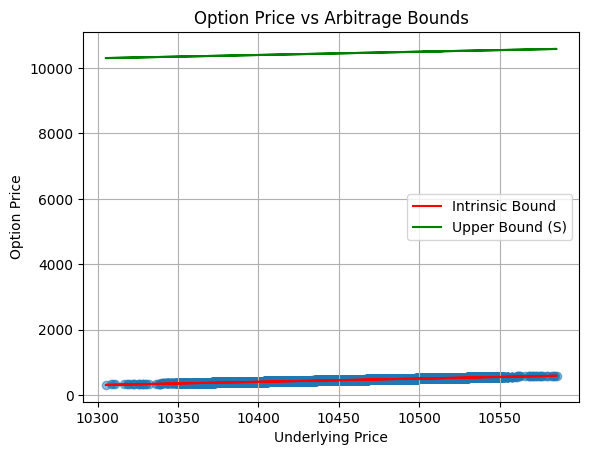

In [28]:
import matplotlib.pyplot as plt

plt.scatter(merged['mid_price_underlying'], merged['mid_price_option'], alpha=0.5)
plt.plot(merged['mid_price_underlying'], 
         np.maximum(merged['mid_price_underlying'] - K, 0), label='Intrinsic Bound', color='red')
plt.plot(merged['mid_price_underlying'], 
         merged['mid_price_underlying'], label='Upper Bound (S)', color='green')
plt.xlabel('Underlying Price')
plt.ylabel('Option Price')
plt.legend()
plt.title('Option Price vs Arbitrage Bounds')
plt.grid(True)
plt.show()